<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94ver4ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd "./drive/My Drive/Data/lettuce"

/content/drive/My Drive/Data/lettuce


In [7]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [143]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import cross_validate
import xgboost as xgb
# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

NUM_BOOST_ROUNDS = 150
METRIC = 'fair'

categoricals = []

FEATURES = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치']
FEATURES_night = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량', 
FEATURES_temp =['내부온도관측치']
FEATURES_light =['시간당백색광량',  '시간당적색광량', '시간당청색광량','시간당총광량']
FEATURES_mean =['시간당백색광량',  '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치','시간당적색광량', '시간당청색광량','시간당총광량']
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)


Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [180]:
def get_time(x, numbers):
    x['DAT'] = x['DAT'].map(lambda x: f'20{numbers}010'+ str(x+1)+' ' if x<9 else f'20{numbers}01'+ str(x+1)+' ' )
    x['obs_time']=x['obs_time'].map(lambda x: x.split(':')[0]+ x.split(':')[1])
    x['시간'] = x['DAT']+x['obs_time']
    x['시간']=pd.to_datetime(x['시간'], format ='%Y%m%d %H%M')
    x[x['시간'].dt.minute == 59]['시간']= x[x['시간'].dt.minute == 59]['시간']+pd.Timedelta(1,'m')
    if 'DAT' and 'obs_time' in list(x.columns):
        x.drop(columns=['DAT','obs_time'], inplace =True)
    else: 
        x.drop(columns =['DAT'],inplace= True)
    x.set_index('시간',inplace =True)
    return x

def get_day(df):
    df_day = df.copy(deep =True)
    df_day['일자'] = df_day.index.day
    df_day['내일일자']=df_day['일자'].map(lambda x: x+1)
    return df_day 

def get_night_time(x):
    X_light_zero = x.copy(deep= True)
    x_zero_list = list(X_light_zero['시간당총광량'].values).count(0)
    x_zero_list = pd.Series(x_zero_list)

    return x_zero_list #결과물은 시리즈로 출력
def day_col_to_row(df):    
    df_row = df.copy(deep =True)
    HOURS_row = 24   
    cols_row = [[f'{col}_{n}' for col in df_row.columns] for n in range(HOURS_row) ]
    cols_row = np.array(cols_row).flatten()      
    # df_sum= pd.DataFrame(columns = df.columns)       
    ar = np.array(df_row).flatten()                                         
    data = pd.Series(ar, index=cols_row)
    return data


def get_sum(x):    
    x_sum = x.copy(deep =True)
    HOURS_sum = 25   
    cols_sum = [[f'{col}_sum' for col in x_sum.columns]  ]
    cols_sum = np.array(cols_sum).flatten()      
    # x_sum= pd.DataFrame(columns = x.columns) 
    x_sum = x_sum.append(x.sum(numeric_only=True), ignore_index=True)
    x_sum = x_sum.iloc[24]        
    ar = np.array(x_sum).flatten()                                         
    data = pd.Series(ar, index=cols_sum)
    return data 
def get_mean(x):    
    x_mean = x.copy(deep =True)
    HOURS_mean = 25   
    cols_mean = [[f'{col}_mean' for col in x_mean.columns]  ]
    cols_mean = np.array(cols_mean).flatten()      
    # x_mean= pd.DataFrame(columns = x.columns) 
    x_mean = x_mean.append(x.mean(numeric_only=True), ignore_index=True)
    x_mean = x_mean.iloc[24]        
    ar = np.array(x_mean).flatten()                                         
    data = pd.Series(ar, index=cols_mean)
    return data 

def get_daily_temp(x):
    X_daily_temp = x.copy(deep =True)
    X_daily_temp_min = x.copy(deep =True)
    X_daily_temp_max = x.copy(deep =True)

    X_daily_temp = X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].max() - X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].min() 
    X_daily_temp= pd.DataFrame(X_daily_temp)
    X_daily_temp.columns = ['일교차']

    X_daily_temp_min=X_daily_temp_min.groupby(X_daily_temp_min.index.date)['내부온도관측치'].min()
    X_daily_temp_min= pd.DataFrame(X_daily_temp_min)
    X_daily_temp_min.columns = ['최저온도']
    X_daily_temp_max = X_daily_temp_max.groupby(X_daily_temp_max.index.date)['내부온도관측치'].max()
    X_daily_temp_max= pd.DataFrame(X_daily_temp_max)
    X_daily_temp_max.columns = ['최고온도']

    X_daily_temp =pd.concat([X_daily_temp,X_daily_temp_min,X_daily_temp_max],axis =1)
    return X_daily_temp

def get_diff(y):
    y_diff=y.diff()
    y_diff =y_diff.fillna(y['predicted_weight_g'][0])
    return y_diff

def get_accumulate(y):
    y_acc =y.cumsum()
    return y_acc

def get_y_time(y, numbers):
    y['DAT'] = y['DAT'].map(lambda y: f'20{numbers}010'+ str(y) if y<9 else f'20{numbers}01'+ str(y))
    y['시간'] = y['DAT']
    y['시간']=pd.to_datetime(y['시간'], format ='%Y%m%d')
    y.drop(columns=['DAT'], inplace =True)
    return y
def get_humid_temp_co2(df):
    df_dot =df.copy(deep =True)
    
    df_dot['습도_온도_co2']=df_dot['내부습도관측치']*df_dot['내부온도관측치']*df_dot['co2관측치']
    df_dot['습도_온도']= df_dot['내부습도관측치']*df_dot['내부온도관측치']
    df_dot['온도_co2'] =df_dot['내부온도관측치']*df_dot['co2관측치']

    # df_dot['빛_온도'] = df_dot['내부온도관측치']*df_dot['시간당총광량']
    # df_dot['빛_습도'] = df_dot['내부습도관측치']*df_dot['시간당총광량']
    # df_dot['빛_co2'] = df_dot['co2관측치']*df_dot['시간당총광량']
    # df_dot['빛_습도_온도_co2'] = df_dot['내부습도관측치']*df_dot['내부온도관측치']*df_dot['co2관측치']*df_dot['시간당총광량']

    # df_dot['온도_ec'] =df_dot['내부온도관측치']*df_dot['ec관측치']
    
    return df_dot
def get_light_ratio(x):
    x_light = x.copy(deep = True)
    x_light['시간당총광량']= x_light['시간당총광량'].map(lambda x: x+1e-4 if x==0 else x)
    x_light['적색/총'] =x_light.시간당적색광량 /x_light.시간당총광량
    x_light['청색/총'] =x_light.시간당청색광량 /x_light.시간당총광량
    x_light['백색/총'] =x_light.시간당백색광량 /x_light.시간당총광량
    return x_light

In [116]:
x=pd.read_csv('./train_input/CASE_02.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
x =get_time(x,numbers)

In [117]:
get_daily_temp(x)

,일교차
2001-01-01,7.323333
2001-01-02,6.061333
2001-01-03,13.161167
2001-01-04,5.755000
2001-01-05,7.088334
2001-01-06,6.901667
2001-01-07,6.676667
2001-01-08,5.961667
2001-01-09,6.921667
2001-01-10,7.663333


In [194]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):

        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return

    def read_data(self, x_file, y_file):
        numbers = re.sub(r'[^0-9]','',x_file)
        numbers_y = re.sub(r'[^0-9]','',y_file)

        x_df = pd.read_csv(x_file)[FEATURES].ffill().bfill()
        x_df2 = pd.read_csv(x_file)
        x_df = get_time(x_df,numbers)
        x_df_night= x_df2.copy(deep= True)
        x_df_night =get_time(x_df_night,numbers)
        x_df_night= x_df_night.groupby(x_df_night.index.date).apply(get_night_time)
        x_df_night.columns = ['소등시간']
        x_df2 = get_time(x_df2,numbers)
        x_df_daily_temp = x_df[FEATURES_temp]
        x_df_light =x_df2[FEATURES_light]
        x_df_light_mean = x_df2.copy(deep =True)[FEATURES_mean]
        x_df_light_mean = get_light_ratio(x_df_light_mean)
        x_df_light_mean = x_df_light_mean.groupby(x_df_light_mean.index.date).apply(get_mean)
        x_df_light =x_df_light.groupby(x_df_light.index.date).apply(get_sum)
        x_df_daily_temp = get_daily_temp(x_df)
        x_df = get_day(x_df)
        # x_df = get_humid_temp_co2(x_df)
        
        # x_df['시간'] = pd.to_datetime(x_df['시간'])
        # x_df.set_index('시간', inplace=True)
         
        x_df = x_df.groupby(x_df.index.date).apply(day_col_to_row)
        y_df = pd.read_csv(y_file)

        if (self.DataType == 'train'):
            y_df =get_y_time(y_df, numbers_y)
            y_df.set_index('시간', inplace=True)
            y_df = get_diff(y_df)
        else:
            y_df =get_y_time(y_df, numbers_y)
            y_df.set_index('시간', inplace=True)
            y_df = get_diff(y_df)

        x_df =pd.concat([x_df,x_df_daily_temp, x_df_light,x_df_light_mean,x_df_night],axis=1)    
        # scaler = StandardScaler()
        # scaler.fit(x_df)
        # x_df.loc[:,x_df.columns] = scaler.transform(x_df)

        return x_df, y_df
    def read_train_raw(self):

        x_list, y_list = [], []
        for No in range(1, 28):                                                
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                
        y_df = pd.concat(y_list)

        return x_df, y_df

    def read_train(self):

        x_list, y_list = [], []
        for No in range(1, 28):                                                 
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                
        y_df = pd.concat(y_list)
        
        return x_df, y_df

    def read_test(self):

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        return x_df, y_df

    def read(self):

        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():

    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):

    test_x, test_y  = LoadData('test', TestNo).read()
    return test_x, test_y

def  load_spilit_train():

    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y

In [160]:
x,y = train_x, train_y = LoadData('train').read_train()

In [162]:
x['내일일자_0']

2001-01-01     2.0
2001-01-02     3.0
2001-01-03     4.0
2001-01-04     5.0
2001-01-05     6.0
              ... 
2027-01-24    25.0
2027-01-25    26.0
2027-01-26    27.0
2027-01-27    28.0
2027-01-28    29.0
Name: 내일일자_0, Length: 756, dtype: float64

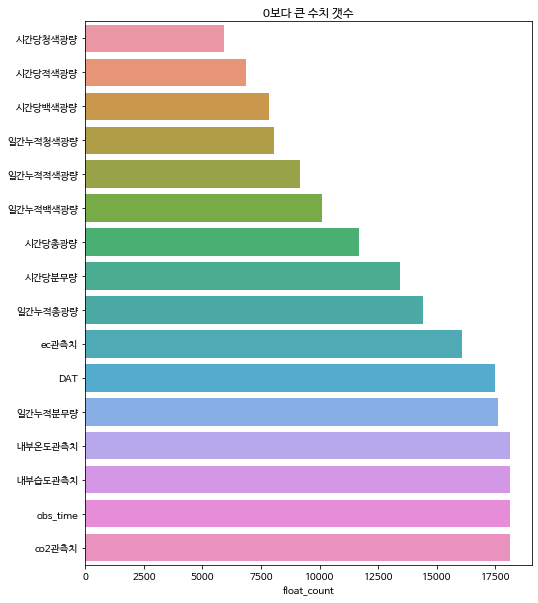

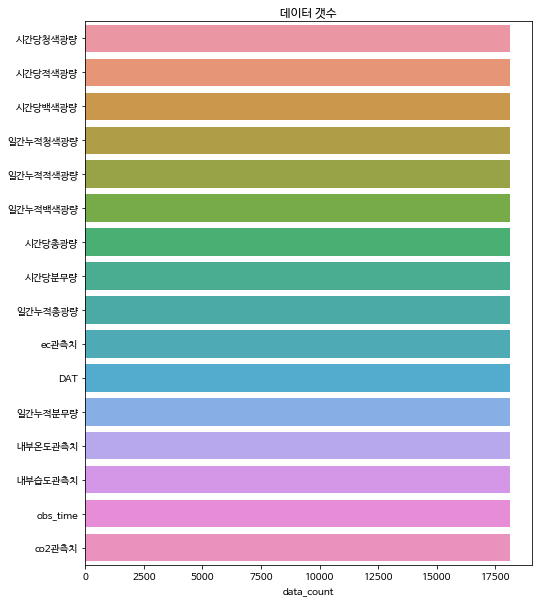

In [126]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

In [173]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [174]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [50,100,150,200,250, 511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

max_bin:  50. RMSE:  2.779
max_bin: 100. RMSE:  2.624
max_bin: 150. RMSE:  2.741
max_bin: 200. RMSE:  2.749
max_bin: 250. RMSE:  2.743
max_bin: 511. RMSE:  2.675
max_bin:2047. RMSE:  2.675
max_bin:4095. RMSE:  2.675
Best max_bin: 100


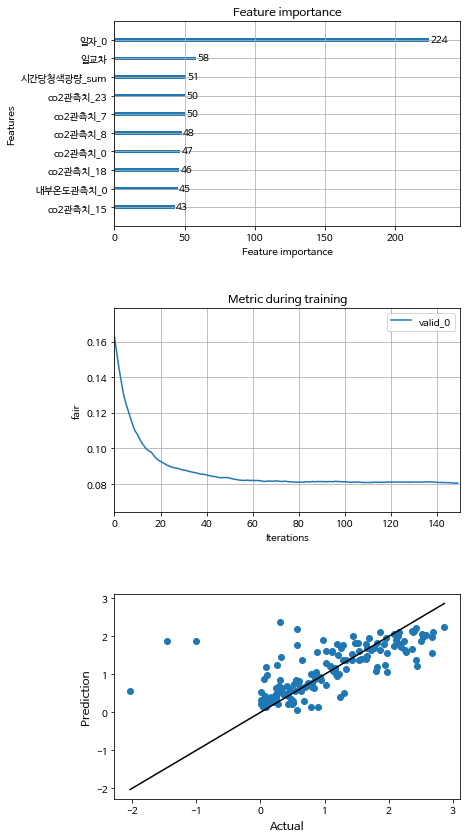

Features Importance Split & Gain...
         feature  split       gain
4           일자_0    224  44.227189
128    co2관측치_21     37   4.248103
26      co2관측치_4     26   2.855098
159    적색/총_mean     32   2.742641
149  시간당청색광량_sum     51   2.520976
109   내부습도관측치_18     26   1.748260
148  시간당적색광량_sum     42   1.723055
161    백색/총_mean     35   1.521203
38      co2관측치_6     32   1.178271
140    co2관측치_23     50   1.048647
110    co2관측치_18     46   1.016034
122    co2관측치_20     23   1.005898
126   내부온도관측치_21     28   0.963445
67    내부습도관측치_11     16   0.940413
20      co2관측치_3     21   0.852288
75      ec관측치_12      9   0.845893
114   내부온도관측치_19     33   0.794896
79    내부습도관측치_13     40   0.711408
145         최저온도     35   0.693613
55     내부습도관측치_9     34   0.675182
57       ec관측치_9     16   0.674738
98     co2관측치_16     26   0.650063
0      내부온도관측치_0     45   0.642668
39       ec관측치_6     14   0.633130
44      co2관측치_7     50   0.630673
2       co2관측치_0     47   0.630603
50      co2관측치_8   

In [195]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [196]:


max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 5                                                                       # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)
    
    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['predicted_weight_g'] = pred_Y
    test_y['predicted_weight_g'] = test_y['predicted_weight_g'].cumsum()
    test_y.index= test_y.index.day

    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')
import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin:  50. RMSE:  2.779
max_bin: 100. RMSE:  2.624
max_bin: 150. RMSE:  2.741
max_bin: 200. RMSE:  2.749
max_bin: 250. RMSE:  2.743
max_bin: 511. RMSE:  2.675
max_bin:2047. RMSE:  2.675
max_bin:4095. RMSE:  2.675
Best max_bin: 100
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 